In [8]:
import pickle
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn import decomposition
import gym

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [9]:
# envname = 'MountainCarContinuous-v0'
envname = 'Pendulum-v0'
demo_file = open('./'+envname+'-demo.pkl', 'rb')
demonstrations = pickle.load(demo_file)[0]

In [10]:
class LatentDynamicModel(object):
    def __init__(self, obs_dim, act_dim, hdim = 64, ldim = 64, epochs = 10000, lr = 1e-5):
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        
        self.seed = 0
        self.epochs = epochs
        
        self.lr = lr
        self.hdim = hdim
        self.ldim = ldim
        
        self.std = 1e-1
        
        self._build_graph()
        self._init_session()

    def _build_graph(self):
        self.g = tf.Graph()
        with self.g.as_default():
            self._placeholders()
            self._vae_nn()
            self._loss_train_op()
            self.init = tf.global_variables_initializer()
            
    def _placeholders(self):
        # observations, actions and advantages:
        self.obs_ph = tf.placeholder(tf.float32, (None, self.obs_dim), 'obs')
        self.next_obs_ph = tf.placeholder(tf.float32, (None, self.obs_dim), 'next_obs')
        self.latent_ph = tf.placeholder(tf.float32, (None, self.ldim), 'latent')
        self.act_ph = tf.placeholder(tf.float32, (None, self.act_dim), 'act')

        # learning rate:
        self.lr_ph = tf.placeholder(tf.float32, (), 'lr')
        self.coeff_dyna = tf.placeholder(tf.float32, (), 'dyna')
        self.coeff_prior = tf.placeholder(tf.float32, (), 'prior')

    def _vae_nn(self):
        self.latent_mean, self.latent_std = self._encoder(self.obs_ph)
        self.latent = self.latent_mean + self.latent_std*tf.random_normal(tf.shape(self.latent_mean))

        self.next_latent_mean, self.next_latent_std = self._encoder(self.next_obs_ph,reuse=True)
        self.next_latent = self.next_latent_mean + self.next_latent_std*tf.random_normal(tf.shape(self.next_latent_mean))
        
        self.control_dynamics, self.control_std = self._dynamics(self.latent)
        self.next_latent_predict = self.latent + tf.reduce_sum(self.control_dynamics*tf.tile(self.act_ph[:,tf.newaxis,:],[1,self.ldim,1]))
        
        self.obs_recon = self._decoder(self.latent)
        self.next_obs_recon = self._decoder(self.next_latent,reuse=True)
        self.obs_gen = self._decoder(self.latent_ph,reuse=True)
          
    def _encoder(self,obs,reuse=False):
        hid1_size = self.hdim
        hid2_size = self.hdim
        latent_size = self.ldim
        
        with tf.variable_scope("encoder"):
            out = tf.layers.dense(obs, hid1_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h1",
                                  reuse=reuse)
            out = tf.layers.dense(out, hid2_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h2",
                                  reuse=reuse)
            out = tf.layers.dense(out, hid2_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h3",
                                  reuse=reuse)
            latent_mean = tf.layers.dense(out, latent_size,
                                    kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), 
                                    name="latent_mean",reuse=reuse)
            latent_std_logits = tf.layers.dense(out, latent_size,
                                    kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), 
                                    name="latent_std",reuse=reuse)
            latent_std = self.std*tf.sigmoid(latent_std_logits)
        return latent_mean, latent_std
    
    def _decoder(self,latent,reuse=False):
        hid1_size = self.hdim
        hid2_size = self.hdim
        
        with tf.variable_scope("decoder"):
            # Decoder for next state
            out = tf.layers.dense(latent, hid1_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h1",
                                  reuse=reuse)
            out = tf.layers.dense(out, hid2_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h2",
                                  reuse=reuse)
            out = tf.layers.dense(out, hid2_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h3",
                                  reuse=reuse)
            obs = tf.layers.dense(out, self.obs_dim,
                                    kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), 
                                    name="obs",reuse=reuse)
        return obs
     
    def _dynamics(self,latent,reuse=False):
        hid1_size = self.hdim
        latent_size = self.ldim
        
        with tf.variable_scope("control_dynamics"):
            # Control Dynamics
            out = tf.layers.dense(latent, hid1_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h1",
                                  reuse=reuse)
            out = tf.layers.dense(out, hid1_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h2",
                                  reuse=reuse)
            out = tf.layers.dense(out, hid1_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h3",
                                  reuse=reuse)
            control_std_logits = tf.layers.dense(out, latent_size,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="std_dynamics",
                                  reuse=reuse)
            control_std = self.std*tf.sigmoid(control_std_logits)
            control_dynamics_flatten = tf.layers.dense(out, latent_size*self.act_dim,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="flatten_dynamics",
                                  reuse=reuse)
            control_dynamics = tf.reshape(control_dynamics_flatten,[-1,latent_size,self.act_dim], name="control_dynamics")
            
        return control_dynamics, control_std
    
    def _loss_train_op(self):
        reconstruction_loss = tf.reduce_sum(tf.squared_difference(self.obs_recon,self.obs_ph))
        next_reconstruction_loss = tf.reduce_sum(tf.squared_difference(self.next_obs_recon,self.next_obs_ph))
        kl_dyna_loss = -0.5*tf.reduce_sum(1+2*tf.log(self.control_std)-2*tf.log(self.next_latent_std)\
                                         - tf.square((self.next_latent_predict - self.next_latent_mean)/self.next_latent_std) - tf.square(self.control_std/self.next_latent_std),axis=1)
        kl_prior_loss = -0.5 * tf.reduce_sum(1 + 2*tf.log(self.latent_std)\
                                             - tf.square(self.latent_mean) - tf.square(self.latent_std), axis=1) 
        self.reconstruction_loss = tf.reduce_mean(reconstruction_loss)
        self.next_reconstruction_loss = tf.reduce_mean(next_reconstruction_loss)
        self.kl_dyna_loss = tf.reduce_mean(kl_dyna_loss)
        self.kl_prior_loss = tf.reduce_mean(kl_prior_loss)
        
        self.vae_loss = self.reconstruction_loss + self.next_reconstruction_loss +  self.coeff_dyna*self.kl_dyna_loss +  self.coeff_prior*self.kl_prior_loss
        
        # OPTIMIZER 
        optimizer = tf.train.AdamOptimizer(self.lr_ph)
        self.train_op = optimizer.minimize(self.vae_loss)
    
    def _init_session(self):
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        self.sess = tf.Session(config=config,graph=self.g)
        self.sess.run(self.init)
        
    def encode(self,obs):
        return self.sess.run(self.latent_mean,feed_dict={self.obs_ph:obs})
    
    def decode(self,latent):
        return self.sess.run(self.obs_gen,feed_dict={self.latent_ph:latent})
        
    def get_control_dynamics(self,obs):
        return self.sess.run(self.control_dynamics,feed_dict={self.obs_ph:obs})
    
    def train(self,obs,act,next_obs,batch_size = 1024):
    
        num_batches = max(obs.shape[0] // batch_size, 1)
        batch_size = obs.shape[0] // num_batches
        
        coeff_dyna = 1e0
        coeff_prior = 1e-5
                
        for e in range(self.epochs+1):
            obs,act,next_obs = shuffle(obs,act,next_obs,random_state=0)
            for j in range(num_batches):
                start = j * batch_size
                end = (j + 1) * batch_size
                feed_dict = {self.obs_ph: obs[start:end,:],
                             self.act_ph: act[start:end,:],
                             self.next_obs_ph: next_obs[start:end,:],
                             self.lr_ph: self.lr, self.coeff_dyna:coeff_dyna, self.coeff_prior:coeff_prior}        
                self.sess.run(self.train_op, feed_dict)
            
            if e < self.epochs/3:
                self.lr = 1e-4
            elif e < 2*self.epochs/3:
                self.lr = 1e-5
            else:
                self.lr = 1e-6

            if (e%500)==0:
                feed_dict = {self.obs_ph: obs,self.act_ph: act,self.next_obs_ph: next_obs, self.lr_ph: self.lr,self.coeff_dyna:coeff_dyna, self.coeff_prior:coeff_prior} 
                vae_loss, recon_loss, kl_dyna_loss, kl_prior_loss = self.sess.run([self.vae_loss,self.reconstruction_loss,self.kl_dyna_loss,self.kl_prior_loss], feed_dict)
                print('[{:05d}/{:05d}] Total : {:.03f}, Recon : {:.03f}, KL Dist : {:.03f}, KL Prior : {:.03f}'.format(e, self.epochs, vae_loss, recon_loss, kl_dyna_loss, kl_prior_loss))
        return vae_loss

In [11]:
env = gym.make(envname)

env.seed(seed=0)

obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]

print(env.observation_space.high)
print(env.observation_space.low)

[2018-07-03 04:43:10,183] Making new env: Pendulum-v0


[1. 1. 8.]
[-1. -1. -8.]


In [12]:
obs = np.concatenate([t['observes'][:-1] for t in demonstrations])
act = np.concatenate([t['actions'][:-1] for t in demonstrations])
next_obs = np.concatenate([t['observes'][1:] for t in demonstrations])
print(obs.shape)
print(act.shape)
print(next_obs.shape)

(19900, 3)
(19900, 1)
(19900, 3)


In [13]:
vae = LatentDynamicModel(obs_dim,act_dim,hdim=128,ldim=64)
nz_obs = (obs - np.mean(obs,axis=0,keepdims=True))/np.std(obs,axis=0,keepdims=True)
nz_next_obs = (next_obs - np.mean(obs,axis=0,keepdims=True))/np.std(obs,axis=0,keepdims=True)
nz_act = act/np.max(np.abs(act),axis=0,keepdims=True)
vae.epochs = 30000
vae.train(nz_obs,nz_act,nz_next_obs)

[00000/30000] Total : 118224.414, Recon : 59699.957, KL Dist : 62.546, KL Prior : 159.804
[00500/30000] Total : 4100.062, Recon : 2126.960, KL Dist : 55.620, KL Prior : 157.268
[01000/30000] Total : 408.251, Recon : 81.810, KL Dist : 245.622, KL Prior : 155.390
[01500/30000] Total : 166.757, Recon : 64.353, KL Dist : 38.995, KL Prior : 142.415
[02000/30000] Total : 160.411, Recon : 61.552, KL Dist : 38.068, KL Prior : 129.527
[02500/30000] Total : 150.381, Recon : 56.470, KL Dist : 38.895, KL Prior : 126.351
[03000/30000] Total : 150.940, Recon : 55.128, KL Dist : 40.244, KL Prior : 123.098
[03500/30000] Total : 145.112, Recon : 54.004, KL Dist : 38.003, KL Prior : 121.918


KeyboardInterrupt: 

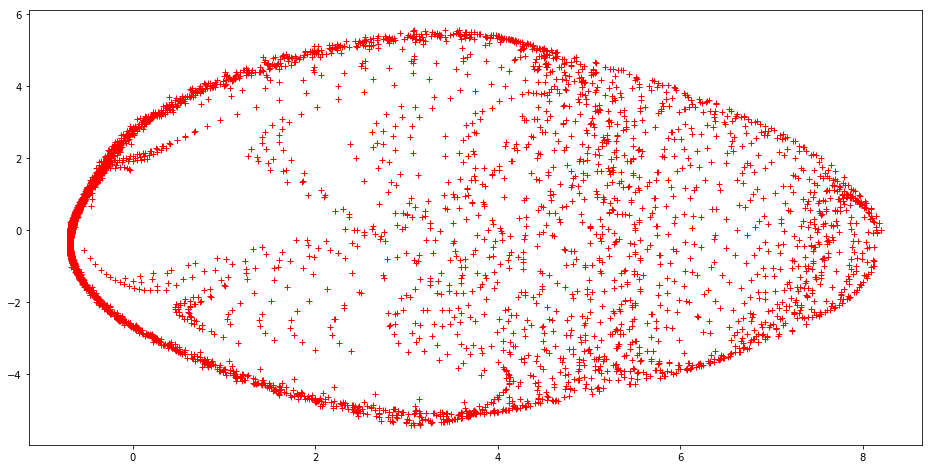

In [22]:
latent = vae.encode(nz_obs)
# latent = vae.encode(data['obs'][2][:10,2:])
pca = decomposition.PCA(n_components=2)
pca.fit(latent)
observes_demo_pca = pca.transform(latent)

fig = plt.figure(figsize=(16, 8))
plt.plot(observes_demo_pca[:,0],observes_demo_pca[:,1],'r+')
plt.show()
# fig = plt.figure(figsize=(16, 8))
# ax = fig.add_subplot(121, projection='3d')
# ax.view_init(90, 60)
# plt.plot(observes_demo_pca[:,0],observes_demo_pca[:,1],observes_demo_pca[:,2],marker='+',c='b')
# ax = fig.add_subplot(122, projection='3d')
# ax.view_init(30, 30)
# plt.plot(observes_demo_pca[:,0],observes_demo_pca[:,1],observes_demo_pca[:,2],marker='+',c='b')
# plt.show()

In [15]:
class Value(object):
    def __init__(self, act_dim, hdim = 16, ldim = 4, epochs = 10000, lr = 1e-3):
        self.act_dim = act_dim
        self.seed = 0
        self.epochs = epochs
        self.lr = lr
        self.hdim = hdim
        self.ldim = ldim
        
        self._build_graph()
        self._init_session()

    def _build_graph(self):
        self.g = tf.Graph()
        with self.g.as_default():
            self._placeholders()
            self._policy_nn()
            self._loss_train_op()
            self.init = tf.global_variables_initializer()
            self.variables = tf.global_variables()
            
    def _placeholders(self):
        # observations, actions and advantages:
        self.latent_ph = tf.placeholder(tf.float32, (None, self.ldim), 'latent')
        self.control_dynamics_ph = tf.placeholder(tf.float32, (None, self.ldim, self.act_dim), 'control_dynamics')
        self.control_ph = tf.placeholder(tf.float32, (None, self.act_dim), 'control')

        # learning rate:
        self.lr_ph = tf.placeholder(tf.float32, (), 'lr')

    def _policy_nn(self):
        
        hid1_size = self.hdim
        hid2_size = self.hdim
        latent_size = self.ldim
        
        with tf.variable_scope("value_network"):
            # Encoder
            out = tf.layers.dense(self.latent_ph, hid1_size, tf.nn.relu,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h1")
            out = tf.layers.dense(out, hid2_size, tf.cosh,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h2")
#             out = tf.layers.dense(out, hid2_size, tf.tanh,
#                                   kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h3")
            self.value = tf.layers.dense(out, 1,
                                    kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), 
                                    name="value")
            self.value_gradients = tf.gradients(self.value,self.latent_ph,name="value_grads")[0]
            self.control = - tf.reduce_sum(tf.tile(self.value_gradients[:,:,tf.newaxis],[1,1,self.act_dim])*self.control_dynamics_ph,axis=1)

    def _loss_train_op(self):        
        # Sum up
        loss = tf.square(self.control_ph - self.control)
        self.loss = tf.reduce_mean(loss)
        
        # OPTIMIZER 
        optimizer = tf.train.AdamOptimizer(self.lr_ph)
        self.train_op = optimizer.minimize(self.loss)
    
    def _init_session(self):
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        self.sess = tf.Session(config=config,graph=self.g)
        self.sess.run(self.init)
    
    def get_control(self,latent,control_dynamics):
        ctrl, val = self.sess.run([self.control, self.value],feed_dict={self.latent_ph:latent,self.control_dynamics_ph:control_dynamics})
        return ctrl, val
#     def get_prediction_trajectory(self,obs,actions):
        
#         for act in actions
    
    def train(self,latent,control_dynamics,control,batch_size = 1024): # TRAIN POLICY
        
        num_batches = max(obs.shape[0] // batch_size, 1)
        batch_size = obs.shape[0] // num_batches
        
        for e in range(self.epochs+1):
            latent,control_dynamics,control = shuffle(latent,control_dynamics,control,random_state=0)
            for j in range(num_batches):
                start = j * batch_size
                end = (j + 1) * batch_size
                feed_dict = {self.latent_ph: latent[start:end,:],
                     self.control_dynamics_ph: control_dynamics[start:end,:,:],
                     self.control_ph: control[start:end,:],
                     self.lr_ph: self.lr}        
                self.sess.run(self.train_op, feed_dict)
            
            if e < self.epochs/3:
                self.lr = 1e-3
            elif e < 2*self.epochs/3:
                self.lr = 1e-4
            else:
                self.lr = 1e-5

            if (e%500)==0:
                feed_dict = {self.latent_ph: latent,
                     self.control_dynamics_ph: control_dynamics,
                     self.control_ph: control}        
                loss = self.sess.run(self.loss, feed_dict)
                print('[{}/{}] Loss : {:f}'.
                      format(e, self.epochs, loss))
        return loss

In [17]:
value = Value(act_dim,hdim=128,ldim=64)

latent = vae.encode(nz_obs)
control_dynamics = vae.get_control_dynamics(nz_obs)
value.epochs = 3000
value.train(latent,control_dynamics,nz_act)

[0/3000] Loss : 0.033052
[500/3000] Loss : 0.007220
[1000/3000] Loss : 0.007131
[1500/3000] Loss : 0.007049
[2000/3000] Loss : 0.007042
[2500/3000] Loss : 0.007024
[3000/3000] Loss : 0.007018


0.0070182104

-236.58694


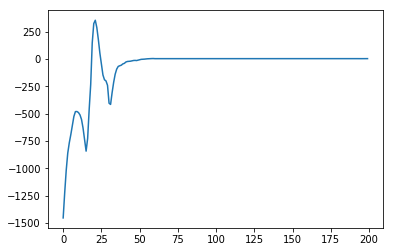

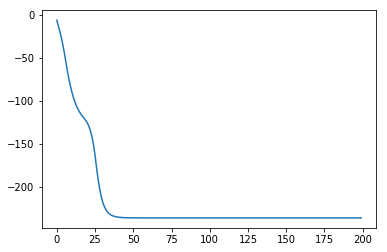

In [24]:
observation = env.reset()
rewards = []
vals = []
frames = []
done = False
while not done:
    
    nz_observation = (observation - np.mean(obs,axis=0))/np.std(obs,axis=0)
    latent = vae.encode([nz_observation])
    control_dynamic = vae.get_control_dynamics([nz_observation])
    nz_action, val = value.get_control(latent,control_dynamic)
#     nz_action = np.clip(nz_action,-1,1)
    action = nz_action*np.max(np.abs(act),axis=0)
    observation, reward, done, info = env.step(action)
    frames.append(env.render("rgb_array"))
    observation = np.squeeze(observation)
    rewards.append(reward)
    vals.append(-val[0][0])

# env.close()

print(np.sum(rewards))
plt.figure()
plt.plot(vals)
plt.figure()
plt.plot(np.cumsum(rewards))
plt.show()

In [25]:
import skvideo.io
outputdata = np.asarray(frames).astype(np.uint8)
skvideo.io.vwrite(envname+"-ioc_pos.mp4", outputdata)